In [1]:
import pandas as pd
import numpy as np
import yfinance as yf

import pandas_ta as ta

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import style

import seaborn as sns

style.use('ggplot')

In [2]:
ativo = 'VALE3'

data = yf.download(ativo+'.SA', period='5y')

[*********************100%***********************]  1 of 1 completed


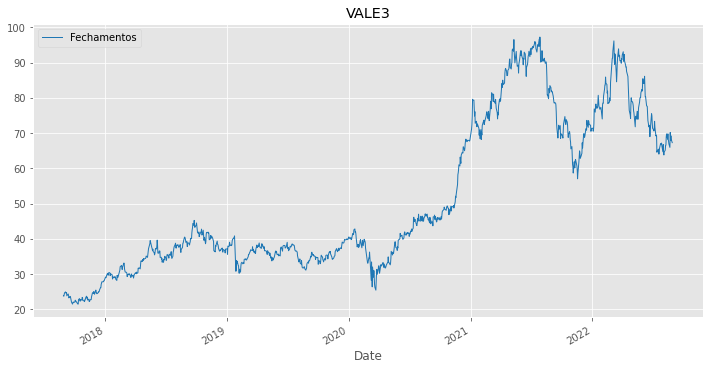

In [3]:
data['Adj Close'].plot(title=ativo, figsize=(12,6), color='tab:blue', lw=1,
                      label='Fechamentos', legend=True);

# Acumulado baseado em Fechamentos

* O ativo é comprado próximo do fechamento da sessão e a posição é encerrada próximo do fechamento do dia seguinte.

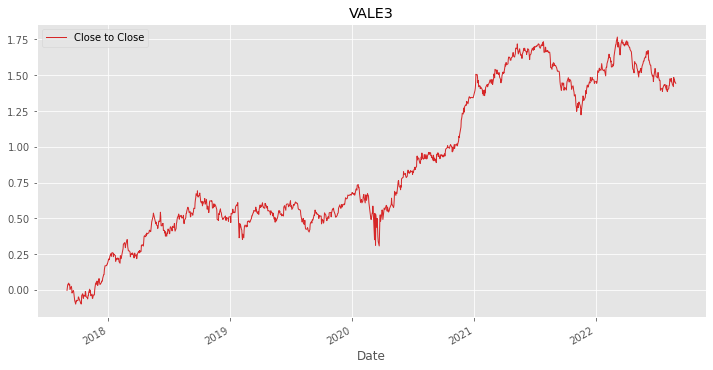

In [4]:
data['close_to_close_return'] = data['Adj Close'].pct_change()
data['close_to_close_return'].cumsum().plot(title=ativo, figsize=(12,6), color='tab:red', lw=1,
                                           label="Close to Close", legend=True);

# Acumulado baseado na Abertura e Fechamento

* O ativo é comprado na abertura da sessão e a posição é encerrada próximo ao fechamento da sessão.

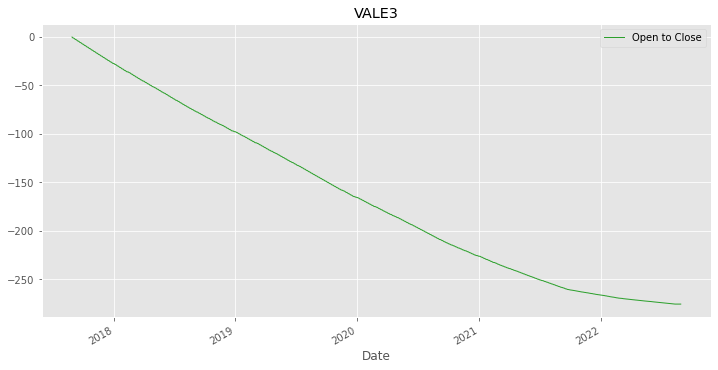

In [5]:
# Intraday returns
data['open_to_close_return'] = (data['Adj Close'] - data['Open'])/data['Open']
data['open_to_close_return'].cumsum().plot(title=ativo, figsize=(12,6), color='tab:green', lw=1,
                                          label="Open to Close", legend=True);

# Acumulado beaseado no Fechamento e Abertura do dia seguinte

* O ativo é comprado próximo ao fechamento do dia e a posição é encerrada na abertura do dia seguinte.

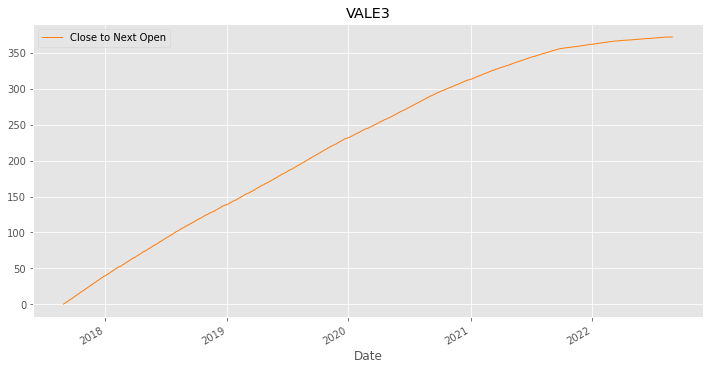

In [6]:
# Overnight returns
data['close_to_open_return'] = data['Open']/data['Adj Close'].shift() - 1
data['close_to_open_return'].cumsum().plot(title=ativo, figsize=(12,6), color='tab:orange', lw=1,
                                          label="Close to Next Open", legend=True);

## Comparativo das 3 Estratégias

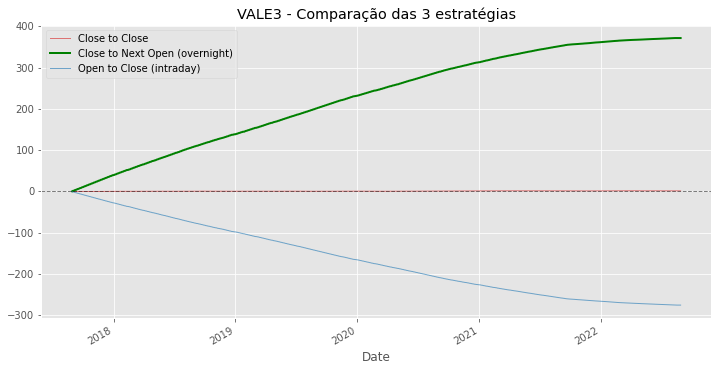

In [7]:
dfpl = data.copy()

# Calc them
dfpl['close_to_close_return'] = dfpl['Adj Close'].pct_change()
dfpl['close_to_open_return'] = dfpl['Open']/dfpl['Adj Close'].shift() - 1
dfpl['open_to_close_return'] = dfpl['Adj Close']/dfpl['Open'] - 1

# All together
plt.title(f'{ativo} - Comparação das 3 estratégias')
dfpl['close_to_close_return'].cumsum().plot(figsize=(12,6), color='tab:red', lw=1, label="Close to Close", alpha=0.6)
dfpl['close_to_open_return'].cumsum().plot(figsize=(12,6), color='green', lw=2, label="Close to Next Open (overnight)")
dfpl['open_to_close_return'].cumsum().plot(figsize=(12,6), color='tab:blue', lw=1, label="Open to Close (intraday)", alpha=0.6)
plt.axhline(y=0, ls='--', lw=1, color='black', alpha=0.5)
plt.legend()
plt.show();

In [8]:
dfpl['week_day'] = dfpl.index.day_of_week
df_week_result = pd.pivot_table(data=dfpl,
                                index='week_day',
                                values='close_to_open_return',
                                aggfunc=np.sum).reset_index()
df_week_result

,week_day,close_to_open_return
0,0,73.018400
1,1,73.667332
2,2,76.596959
3,3,75.324125
4,4,73.092348


Ao longo dos anos, podemos ver que há uma constância nos resultados por dia das semanas. O destaque fica para a **quarta** e **quinta** com um acumulado maior do que os outros dias.

In [9]:
dfpl['year'] = dfpl.index.year
df_year_result = pd.pivot_table(data=dfpl,
               index='year',
               values='close_to_open_return',
               aggfunc=np.sum).reset_index()
df_year_result

,year,close_to_open_return
0,2017,39.292196
1,2018,99.033909
2,2019,93.290247
3,2020,81.213175
4,2021,48.831744
5,2022,10.037893


Nos 5 anos observados podemos ver que tivemos um *BOOM* nos anos de 2018, 2019 e 2020. E também podemos constatar que nos outros anos temos números mais baixos, mas ainda assim bem positivos.

## Calculando o drawdown

In [10]:
drawdown = ta.drawdown(dfpl['close_to_open_return'].cumsum())['DD']*100*-1

## Gerando gráfico com resultados

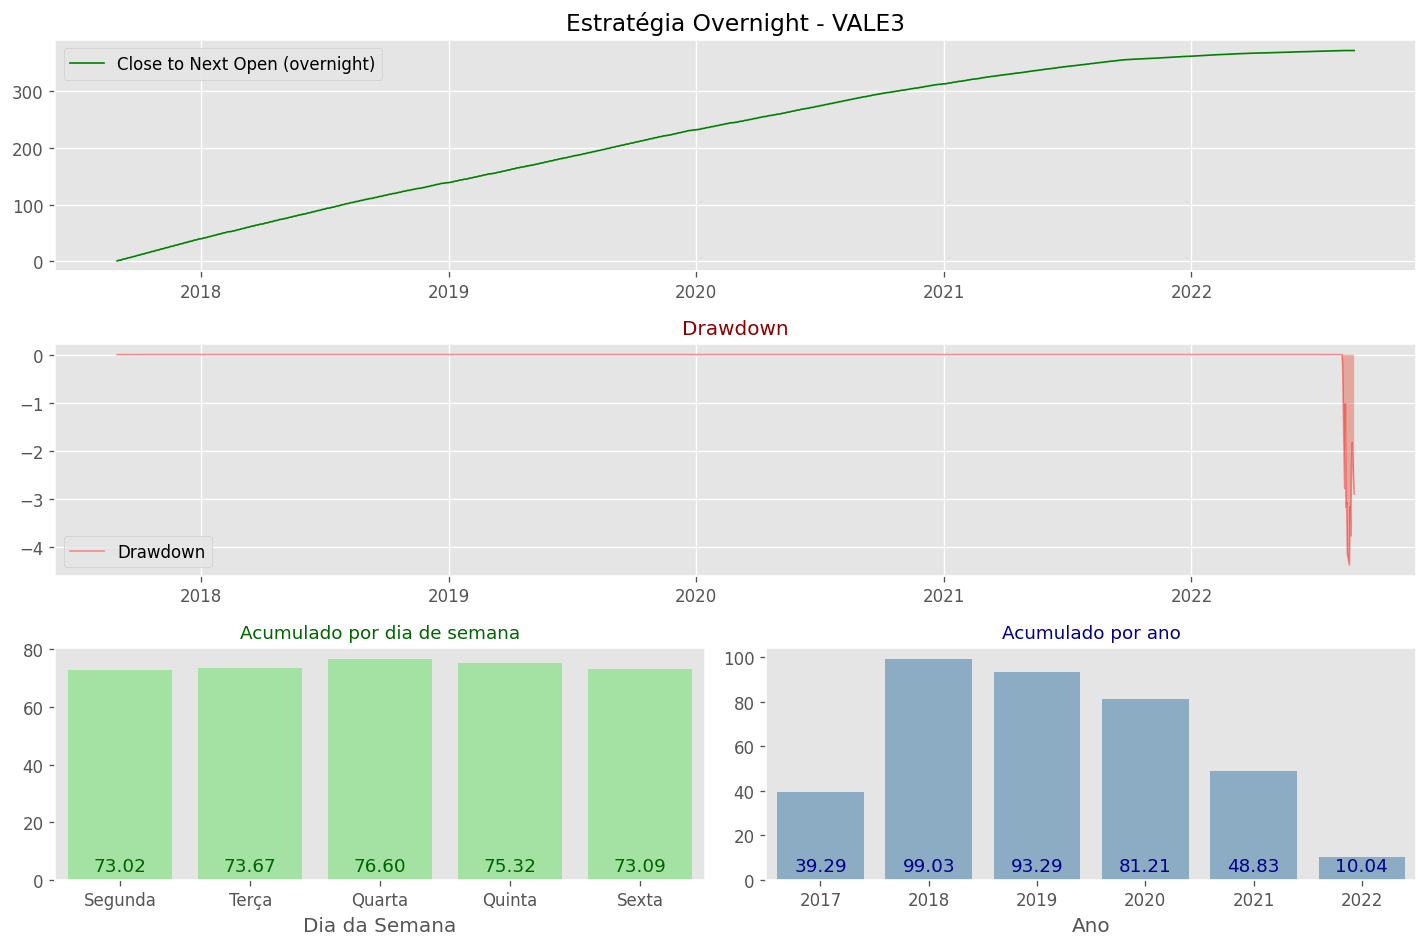

In [11]:
fig = plt.figure(dpi=120, figsize=(12, 8))
gs = GridSpec(nrows=3, ncols=2, figure=fig)

ax1 = fig.add_subplot(gs[0, 0:])
ax1.set_title(f'Estratégia Overnight - {ativo}', fontdict={'size':14})
ax1.plot(dfpl['close_to_open_return'].cumsum(), color='green', lw=1, label='Close to Next Open (overnight)')
ax1.legend()

ax2 = fig.add_subplot(gs[1, 0:])
ax2.set_title('Drawdown', fontdict={'size':12, 'color':'darkred'})
ax2.plot(drawdown, color='red', lw=1, alpha=0.4, label='Drawdown')
ax2.fill_between(drawdown.index, y1=drawdown, alpha=0.4)
ax2.legend()

ax3 = fig.add_subplot(gs[2, 0:1])
ax3.set_title('Acumulado por dia de semana', fontdict={'size':11, 'color': 'darkgreen'})
ax3.set_xticks(range(len(df_week_result)), ['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta'])
plots = sns.barplot(x="week_day", y="close_to_open_return", data=df_week_result,
                    color='lightgreen', alpha=0.9)

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    0), ha='center', va='center',
                   size=11, xytext=(0, 8), color='darkgreen',
                   textcoords='offset points')
ax3.set_xticks(range(len(df_week_result)), ['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta'])
ax3.set_ylabel(None)
ax3.set_xlabel('Dia da Semana')
ax3.grid(False)

ax4 = fig.add_subplot(gs[2, 1:])
ax4.set_title('Acumulado por ano', fontdict={'size':11, 'color':'darkblue'})
plots2 = sns.barplot(x="year", y="close_to_open_return", data=df_year_result,
                    color='tab:blue', alpha=0.5)

for bar2 in plots2.patches:
    plots2.annotate(format(bar2.get_height(), '.2f'),
                    (bar2.get_x() + bar2.get_width() / 2, 0),
                    ha='center', va='center',
                    size=11, xytext=(0, 8), color='darkblue',
                    textcoords='offset points')

ax4.set_ylabel(None)
ax4.set_xlabel('Ano')
ax4.grid(False)

plt.tight_layout()
plt.show()

## Estatísticas finais

In [12]:
df_stats = dfpl.fillna(0).copy()

mean_gain = round(df_stats[df_stats['close_to_open_return'] > 0]['close_to_open_return'].mean()*100, 2)
mean_loss = round(df_stats[df_stats['close_to_open_return'] <= 0]['close_to_open_return'].mean()*100, 2)

total_trades = df_stats.shape[0]
count_gain = len(df_stats[df_stats['close_to_open_return'] > 0])
count_loss = len(df_stats[df_stats['close_to_open_return'] <= 0])

percent_gain = round((count_gain/total_trades)*100, 2)
percent_loss = round((count_loss/total_trades)*100, 2)

acc = df_stats['close_to_open_return'].cumsum()

final_return = round(acc.iloc[-1], 2)
max_drawdown = round(ta.max_drawdown(acc)*100, 2)

payoff = round(mean_gain/abs(mean_loss), 2)

print(f'\n{ativo}\n\n')

print(f'Total de operações: {total_trades}')
print(f'Quantidade de Gains: {count_gain}')
print(f'Quantidade de Losses: {count_loss}')

print(f'\nPercentual de Gains: {percent_gain}%')
print(f'Percentual de Loss: {percent_loss}%')

print(f'\nMédia Gain: {mean_gain}')
print(f'Média Loss: {mean_loss}')

print(f'\nPayoff: {payoff}')

print(f'\nRetorno final: {final_return}%')
print(f'Drawdown Máximo: {max_drawdown}%')


VALE3


Total de operações: 1244
Quantidade de Gains: 1236
Quantidade de Losses: 8

Percentual de Gains: 99.36%
Percentual de Loss: 0.64%

Média Gain: 30.08
Média Loss: -0.99

Payoff: 30.38

Retorno final: 371.7%
Drawdown Máximo: 4.37%
